# General Travelling Sales Person

In addition to being a notorious NP-hard problem that has drawn the attention of computer scientists and mathematicians for over two centuries, the Traveling Salesman Problem (TSP) has important bearings on finance and marketing, as its name suggests. 

Colloquially speaking, the traveling salesman is a person that goes from city to city to sell merchandise. The objective in this case is to find the shortest path that would enable the salesman to visit all the cities and return to its hometown, i.e. the city where he started traveling. By doing this, the salesman gets to maximize potential sales in the least amount of time.

The problem derives its importance from its “hardness” and ubiquitous equivalence to other relevant combinatorial optimization problems that arise in practice.

The mathematical formulation with some early analysis was proposed by W.R. Hamilton in the early 19th century. Mathematically the problem is, as in the case of Max-Cut, best abstracted in terms of network graphs. 

The TSP on the nodes of a graph asks for the shortest Hamiltonian cycle that can be taken through each of the nodes. A Hamilton cycle is a closed path that uses every vertex of a graph once. The general solution is unknown and an algorithm that finds it efficiently (e.g., in polynomial time) is not expected to exist.



In [2]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Standard Libraries
import argparse
import json
import time
import networkx as nx
import numpy as np
from joblib import Parallel, delayed
import mlflow
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Custom Libraries
import qaoa_vrp.build_graph
import qaoa_vrp.features.graph_features
import qaoa_vrp.features.tsp_features
import qaoa_vrp.build_circuit
import qaoa_vrp.clustering
import qaoa_vrp.utils
from qaoa_vrp.exp_utils import str2bool, make_temp_directory
from qaoa_vrp.quantum_burden import compute_quantum_burden
from qaoa_vrp.classical.greedy_tsp import greedy_tsp
from qaoa_vrp.plot.draw_euclidean_graphs import draw_euclidean_graph

# QISKIT stuff
from qiskit import Aer, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver,VQE
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.components.optimizers import ADAM, AQGD, COBYLA, NELDER_MEAD, SPSA
from qiskit.circuit import Parameter
from qiskit.finance.applications.ising import portfolio
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.converters import QuadraticProgramToQubo
from qiskit.optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
)
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.applications.ising import max_cut, tsp


In [3]:
filename="instanceType_euclidean_tsp_numNodes_4_numVehicles_1_87a170c748e240d0b71d5fb7fe7de707.json"
instance_path = "../data/{}".format(filename)
with open(instance_path) as f:
        data = json.load(f)

In [4]:
# Build Graph
G, depot_info = qaoa_vrp.build_graph.build_json_graph(data["graph"])
num_vehicles = int(data["numVehicles"])
threshold = float(data["threshold"])
n_max = int(data["n_max"])
instance_type = data["instance_type"]
p_max = data["p_max"]


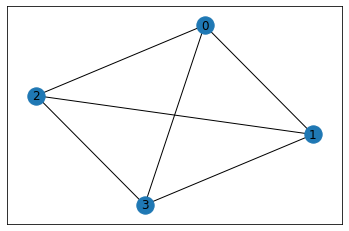

In [5]:
nx.draw_networkx(G)

In [6]:
# Create QAOA parameter dictionary
qaoa_dict = qaoa_vrp.utils.create_qaoa_params(threshold, n_max, p_max)

In [7]:
# Build Graph Feature Vector
feature_vector = qaoa_vrp.features.graph_features.get_graph_features(G)
# Build TSP Feature Vector
tsp_feature_vector = qaoa_vrp.features.tsp_features.get_tsp_features(G)
# Add num vehicles
feature_vector["num_vehicles"] = num_vehicles

In [8]:
depot_edges = list(G.edges(depot_info["id"], data=True))
depot_node = depot_info["id"]

In [9]:
edge_mat = nx.linalg.graphmatrix.adjacency_matrix(G).toarray()
cost_mat = np.array(nx.attr_matrix(G, edge_attr="cost", rc_order=list(G.nodes())))

In [10]:
G, cluster_mapping = qaoa_vrp.clustering.create_clusters(
    G, num_vehicles, "spectral-clustering", edge_mat
)

subgraphs = qaoa_vrp.clustering.build_sub_graphs(G, depot_node, depot_edges)

qubos = qaoa_vrp.build_circuit.build_qubos(subgraphs, depot_info)

qubos_solution_data = []

cluster_mapping = [i + 1 for i in cluster_mapping]
cluster_mapping.insert(0, 0)

In [12]:
qubo = qubos[0]
qubo

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 119.870490707263 X11 - 120 X12 - 119.870490707263 X13
      - 119.544965007869 X21 - 120 X22 - 119.544965007869 X23
      - 119.830216603413 X31 - 120 X32 - 119.830216603413 X33 + [ 120 X11^2
      + 120 X11*X12 + 120 X11*X13 + 120 X11*X21 + 0.656366125546 X11*X22
      + 120 X11*X31 + 0.573070695708 X11*X32 + 120 X12^2 + 120 X12*X13
      + 0.656366125546 X12*X21 + 120 X12*X22 + 0.656366125546 X12*X23
      + 0.573070695708 X12*X31 + 120 X12*X32 + 0.573070695708 X12*X33
      + 120 X13^2 + 0.656366125546 X13*X22 + 120 X13*X23
      + 0.573070695708 X13*X32 + 120 X13*X33 + 120 X21^2 + 120 X21*X22
      + 120 X21*X23 + 120 X21*X31 + 1.227988238243 X21*X32 + 120 X22^2
      + 120 X22*X23 + 1.227988238243 X22*X31 + 120 X22*X32
      + 1.227988238243 X22*X33 + 120 X23^2 + 1.227988238243 X23*X32
      + 120 X23*X33 + 120 X31^2 + 120 X31*X32 + 120 X31*X33 + 120 X32^2
      + 120 X32*X33 + 1

In [13]:
single_qubo_solution_data = {}
single_qubo_solution_data["qubo_id"] = 0
single_qubo_solution_data["cluster"] = [
    index
    for index, node in enumerate(cluster_mapping)
    if node == 1 or node == 0
]
num_nodes=len(single_qubo_solution_data['cluster'])

In [14]:
single_qubo_solution_data

{'qubo_id': 0, 'cluster': [0, 1, 2, 3, 4]}

# Solving the QAOA

In [15]:
# Here we go
evolution_data = []
n = 0
p = 1 # p-ticker
backend = "statevector_simulator" # Use MPS
probability = [0, 0] # 2 probabilities associated with symettric solutions (total p = p_0 + p_1)
points = list(2 * np.pi * np.random.random(2 * p)) # Initial trials for \alpha and \beta

Lets write some basic functions to find the solution from the result and also one to compute the cost based on our original graph

In [16]:
def build_solution(solution_bit_str):
    sols_list = [0]
    for i in range(int(np.sqrt(len(solution_bit_str)))):
        city_visited = exact_sol_str[i*4:(i+1)*4].index('1') + 1
        sols_list.append(city_visited)
    sols_list.append(0)
    return sols_list

def compute_cost(sol, G):
    cost = 0
    for i,node in enumerate(sol):
        if i < len(sol)-1:
            cost += G[node][sol[i+1]]['cost']
    return cost

In [17]:
op, offset = qubo.to_ising()
num_qubits = qubo.get_num_vars()

In [18]:
print('Offset:', offset)
print('Ising Hamiltonian:')
print(op.print_details())

Offset: 181.9830402112039
Ising Hamiltonian:
IIIIIIIIZ	(-30.218434249025503+0j)
IIIIIIZII	(-30.2184342490255+0j)
IIIIIZIII	(-30.463061791538866+0j)
IIIZIIIII	(-30.463061791538866+0j)
IIZIIIIII	(-30.310024065037577+0j)
ZIIIIIIII	(-30.31002406503758+0j)
IIIIIIIZI	(-30.307359205313634+0j)
IIIIZIIII	(-30.471088590947225+0j)
IZIIIIIII	(-30.45026473348771+0j)
IIIIIIIZZ	(15+0j)
IIIIIIZIZ	(15+0j)
IIIIIIZZI	(15+0j)
IIIIIZIIZ	(15+0j)
IIIIIZIZI	(0.082045765693287+0j)
IIIIZIIIZ	(0.082045765693287+0j)
IIIIZIIZI	(15+0j)
IIIIZIZII	(0.082045765693287+0j)
IIIIZZIII	(15+0j)
IIIZIIIZI	(0.082045765693287+0j)
IIIZIIZII	(15+0j)
IIIZIZIII	(15+0j)
IIIZZIIII	(15+0j)
IIZIIIIIZ	(15+0j)
IIZIIIIZI	(0.07163383696353035+0j)
IIZIIZIII	(15+0j)
IIZIZIIII	(0.15349852978032563+0j)
IZIIIIIIZ	(0.07163383696353035+0j)
IZIIIIIZI	(15+0j)
IZIIIIZII	(0.07163383696353035+0j)
IZIIIZIII	(0.15349852978032563+0j)
IZIIZIIII	(15+0j)
IZIZIIIII	(0.15349852978032563+0j)
IZZIIIIII	(15+0j)
ZIIIIIIZI	(0.07163383696353035+0j)
ZIIIIIZII	(15+0

In [20]:
qp = QuadraticProgram()
qp.from_ising(op, offset, linear=True)
qp.to_docplex().prettyprint()

// This file has been generated by DOcplex
// model name is: AnonymousModel
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;
dvar bool x_4;
dvar bool x_5;
dvar bool x_6;
dvar bool x_7;
dvar bool x_8;

minimize
 - 59.870491 x_0 - 60.000000 x_1 - 59.870491 x_2 - 59.544965 x_3 - 60 x_4
 - 59.544965 x_5 - 59.830217 x_6 - 60 x_7 - 59.830217 x_8 [ 60 x_0*x_1
 + 60 x_0*x_2 + 60 x_0*x_3 + 0.328183 x_0*x_4 + 60 x_0*x_6 + 0.286535 x_0*x_7
 + 60 x_1*x_2 + 0.328183 x_1*x_3 + 60 x_1*x_4 + 0.328183 x_1*x_5
 + 0.286535 x_1*x_6 + 60 x_1*x_7 + 0.286535 x_1*x_8 + 0.328183 x_2*x_4
 + 60 x_2*x_5 + 0.286535 x_2*x_7 + 60 x_2*x_8 + 60 x_3*x_4 + 60 x_3*x_5
 + 60 x_3*x_6 + 0.613994 x_3*x_7 + 60 x_4*x_5 + 0.613994 x_4*x_6 + 60 x_4*x_7
 + 0.613994 x_4*x_8 + 0.613994 x_5*x_7 + 60 x_5*x_8 + 60 x_6*x_7 + 60 x_6*x_8
 + 60 x_7*x_8 ] + 180.000000;
 
subject to {

}


In [21]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
exact_result = exact.solve(qp)
print(exact_result)

optimal function value: 1.2395367993452528
optimal value: [0. 1. 0. 0. 0. 1. 1. 0. 0.]
status: SUCCESS


In [22]:
ee = NumPyMinimumEigensolver(op)
result = ee.run()

In [29]:
print('energy:', result.eigenvalue.real)
print('tsp objective:', result.eigenvalue.real + offset)
x = sample_most_likely(result.eigenstate)
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, cost_mat))

energy: -180.74350341185865
tsp objective: 1.2395367993452453
feasible: True
solution: [2, 0, 1]
solution objective: 0.9127273476410219


## Running it on quantum computer
We run the optimization routine using a feedback loop with a quantum computer that uses trial functions built with Y single-qubit rotations, $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, and entangler steps $U_{entangler}$.

In [30]:
aqua_globals.random_seed = np.random.default_rng(123)
seed = 10598
backend = Aer.get_backend('aer_simulator_matrix_product_state')
# Parameeters based on minimising
spsa = SPSA(maxiter=1000, c0=0.0001, c1=0.0001)
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)
qaoa = QAOA(
    operator=op,
    optimizer=spsa,
    p=1,
    initial_point=[0.12,0.01],
    quantum_instance=quantum_instance
)



result_qaoa = qaoa.run(quantum_instance)

In [46]:
print('energy:', result.eigenvalue.real)
# print('time:', result.optimizer_time)
x = sample_most_likely(result.eigenstate)
try:
    z = tsp.get_tsp_solution(x)
    print('feasible:', tsp.tsp_feasible(x))    
    print('solution objective:', tsp.tsp_value(z, cost_mat))
    print('solution:', z)
except:
    print('feasible:', tsp.tsp_feasible(x))

energy: -180.74350341185865
feasible: True
solution objective: 0.9127273476410219
solution: [2, 0, 1]


## Try with VQE 

In [47]:
ry = TwoLocal(op.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
vqe = VQE(op, ry, spsa, quantum_instance=quantum_instance)
result_vqe = vqe.run(quantum_instance)
print('energy:', result_vqe.eigenvalue.real)
print('time:', result_vqe.optimizer_time)
x = sample_most_likely(result_vqe.eigenstate)
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)

energy: -35.54709327932248
time: 928.6647448539734
feasible: False
solution: [[0, 1], 2, 0]


In [48]:
def create_results_df(result, exact_result, algo, sort_var='solution'):
    if algo == "vqe":
        df = [{'state':key, 'count':result.data['eigenstate'][key]} for key in result.data['eigenstate'].keys()]
    elif algo == "qaoa":
        df = [{'state':key, 'count':result.min_eigen_solver_result['eigenstate'][key]} for key in result.min_eigen_solver_result['eigenstate'].keys()]
    df = pd.DataFrame.from_records(df)
    exact_sol_bit_str = ''.join([str(int(i)) for i in exact_result.x])
    df = df.assign(decimal = lambda df: df['state'].map(lambda state: int(state, 2)))
    df = df.assign(solution = lambda df: df['state'].map(lambda state: True if exact_sol_bit_str == state else False) )
    df = df.sort_values(by=sort_var,ascending=False)
    return df

In [53]:
d_vqe = create_results_df(result_vqe, exact_result, 'vqe')
d_qaoa = create_results_df(result_qaoa, exact_result, 'vqe')

{'011110110': 1,
 '111100000': 1,
 '100111000': 1,
 '100100011': 1,
 '100111100': 1,
 '111100100': 1,
 '001110010': 1,
 '101001110': 1,
 '000001001': 1,
 '110000010': 2,
 '011110111': 1,
 '001001000': 1,
 '001001101': 2,
 '011100011': 1,
 '101101111': 1,
 '011000010': 1,
 '000001010': 1,
 '000010100': 1,
 '011000111': 1,
 '101100111': 1,
 '111101011': 1,
 '100011110': 1,
 '110101011': 1,
 '001101011': 1,
 '110000110': 3,
 '000001000': 1,
 '100010001': 1,
 '110110111': 1,
 '010011111': 1,
 '101010010': 4,
 '101011011': 2,
 '100110110': 1,
 '101110101': 1,
 '011100111': 1,
 '010000011': 1,
 '111010011': 3,
 '111100111': 1,
 '000110000': 2,
 '111100010': 1,
 '011011010': 4,
 '111011110': 2,
 '110001011': 2,
 '010010100': 1,
 '100000110': 1,
 '110010111': 2,
 '000111000': 1,
 '110100011': 1,
 '101101000': 3,
 '011000000': 2,
 '110100101': 1,
 '101101110': 2,
 '110111010': 1,
 '000111011': 1,
 '000100010': 2,
 '100100001': 2,
 '011101010': 2,
 '000000010': 4,
 '110011110': 1,
 '110111001': 

In [62]:
d_qaoa.sort_values(by='count',ascending=False)

,state,count,decimal,solution
433,101011000,7,344,False
324,100010100,6,276,False
318,111111101,6,509,False
241,111110010,6,498,False
93,100111010,6,314,False
...,...,...,...,...
425,110011100,1,412,False
49,110100101,1,421,False
429,001101001,1,105,False
46,110100011,1,419,False


In [58]:
d_vqe.sort_values(by='count',ascending=False)
d_vqe

,state,count,decimal,solution
191,010001100,40,140,True
0,111101101,1,493,False
146,100101111,1,303,False
136,100101100,1,300,False
137,001110111,2,119,False
...,...,...,...,...
74,111110100,2,500,False
75,110000101,5,389,False
76,001110000,2,112,False
77,101011101,1,349,False


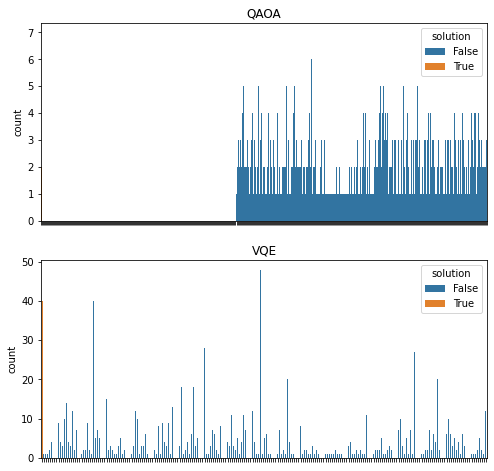

In [56]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))

# Plot QAOA
p_qaoa = sns.barplot(x="state", y="count", hue="solution", data=d_qaoa, ax=ax[0])
p_qaoa.set(xticklabels=[])  # remove the tick labels
p_qaoa.set(title='QAOA')  # add a title
p_qaoa.set(xlabel=None)  # remove the axis label # remove the axis label

# Plot VQE
p_vqe = sns.barplot(x="state", y="count", hue="solution", data=d_vqe,ax=ax[1])
p_vqe.set(xticklabels=[])  # remove the tick labels
p_vqe.set(title='VQE')  # add a title
p_vqe.set(xlabel=None)  # remove the axis label# remove the ticks

plt.show()

In [271]:
# # Lets increase P
# num_optimisation_calls = [result_solver.min_eigen_solver_result['optimizer_evals']]
# # print(num_optimisation_calls)
# p = 1
# while p < 10:
#     p += 1
#     print("Increasing p to p=%s"%p)
#     op, offset = qubo.to_ising()
#     num_qubits = qubo.get_num_vars()
#     method = QasmSimulator(method="statevector")
#     quantum_instance = QuantumInstance(
#             method,
#             seed_transpiler=aqua_globals.random_seed,
#         )
#     qaoa_meas = QAOA(
#             quantum_instance=quantum_instance,
#             p=p,
#             initial_point=list(2 * np.pi * np.random.random(2 * p)),
#         )
#     qaoa = MinimumEigenOptimizer(qaoa_meas)
#     qaoa_result = qaoa.solve(qubo)
#     fevals = qaoa_result.min_eigen_solver_result['optimizer_evals']
#     num_optimisation_calls.append(fevals)
    

In [60]:
result_qaoa.eigenstate

{'011110110': 1,
 '111100000': 1,
 '100111000': 1,
 '100100011': 1,
 '100111100': 1,
 '111100100': 1,
 '001110010': 1,
 '101001110': 1,
 '000001001': 1,
 '110000010': 2,
 '011110111': 1,
 '001001000': 1,
 '001001101': 2,
 '011100011': 1,
 '101101111': 1,
 '011000010': 1,
 '000001010': 1,
 '000010100': 1,
 '011000111': 1,
 '101100111': 1,
 '111101011': 1,
 '100011110': 1,
 '110101011': 1,
 '001101011': 1,
 '110000110': 3,
 '000001000': 1,
 '100010001': 1,
 '110110111': 1,
 '010011111': 1,
 '101010010': 4,
 '101011011': 2,
 '100110110': 1,
 '101110101': 1,
 '011100111': 1,
 '010000011': 1,
 '111010011': 3,
 '111100111': 1,
 '000110000': 2,
 '111100010': 1,
 '011011010': 4,
 '111011110': 2,
 '110001011': 2,
 '010010100': 1,
 '100000110': 1,
 '110010111': 2,
 '000111000': 1,
 '110100011': 1,
 '101101000': 3,
 '011000000': 2,
 '110100101': 1,
 '101101110': 2,
 '110111010': 1,
 '000111011': 1,
 '000100010': 2,
 '100100001': 2,
 '011101010': 2,
 '000000010': 4,
 '110011110': 1,
 '110111001': 

In [61]:
result_vqe.eigenstate

{'111101101': 1,
 '001100000': 1,
 '011000100': 1,
 '010001010': 1,
 '100111101': 1,
 '110100001': 1,
 '000110011': 2,
 '011111100': 1,
 '100010001': 1,
 '101000101': 1,
 '100101010': 1,
 '010101010': 1,
 '001101000': 3,
 '011100011': 4,
 '000100011': 1,
 '011000011': 1,
 '011001101': 2,
 '001100010': 1,
 '010011100': 2,
 '100110011': 1,
 '101011001': 1,
 '101101101': 11,
 '111111100': 1,
 '010001110': 1,
 '111100010': 1,
 '011000111': 1,
 '001010000': 1,
 '001001011': 1,
 '101011100': 1,
 '101000100': 1,
 '011011000': 3,
 '010000100': 7,
 '011100110': 1,
 '000000100': 7,
 '101111100': 1,
 '000110111': 2,
 '001111111': 1,
 '000001100': 20,
 '001000100': 4,
 '011000101': 1,
 '100001011': 1,
 '101101111': 1,
 '001010001': 1,
 '000001001': 8,
 '000011010': 1,
 '101010110': 2,
 '000111001': 2,
 '110011010': 1,
 '101111101': 1,
 '010110011': 3,
 '000100100': 1,
 '100101000': 2,
 '011110011': 2,
 '001110011': 2,
 '011110001': 2,
 '000110100': 5,
 '100010101': 2,
 '101001001': 1,
 '001110101'

In [64]:
tsp.get_tsp_solution(x)

[[0, 1], 2, 0]

In [ ]:
tsp.